In [1]:
import cv2
import numpy as np
from skimage import (feature,measure)
from scipy import ndimage
%pylab inline
from skimage.transform import (hough_circle,hough_circle_peaks)
from skimage.draw import circle_perimeter
from skimage import data, color, img_as_ubyte
import imutils
from imutils import contours

Populating the interactive namespace from numpy and matplotlib


In [2]:
## Metalografía 1

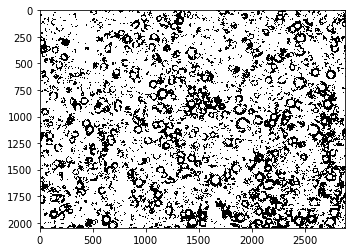

In [3]:
img = cv2.imread('./FeNod_50X_L.tif')
gray =cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh,cmap=cm.gray)
plt.show()

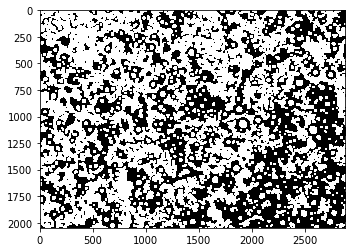

In [4]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 8)
erode = cv2.erode(opening,kernel,iterations = 3)
plt.imshow(opening,cmap=cm.gray)
plt.show()

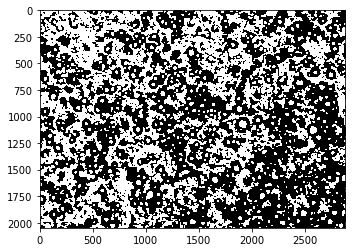

dtype('uint8')

In [5]:
plt.imshow(erode,cmap=cm.gray)
plt.show()
erode.dtype

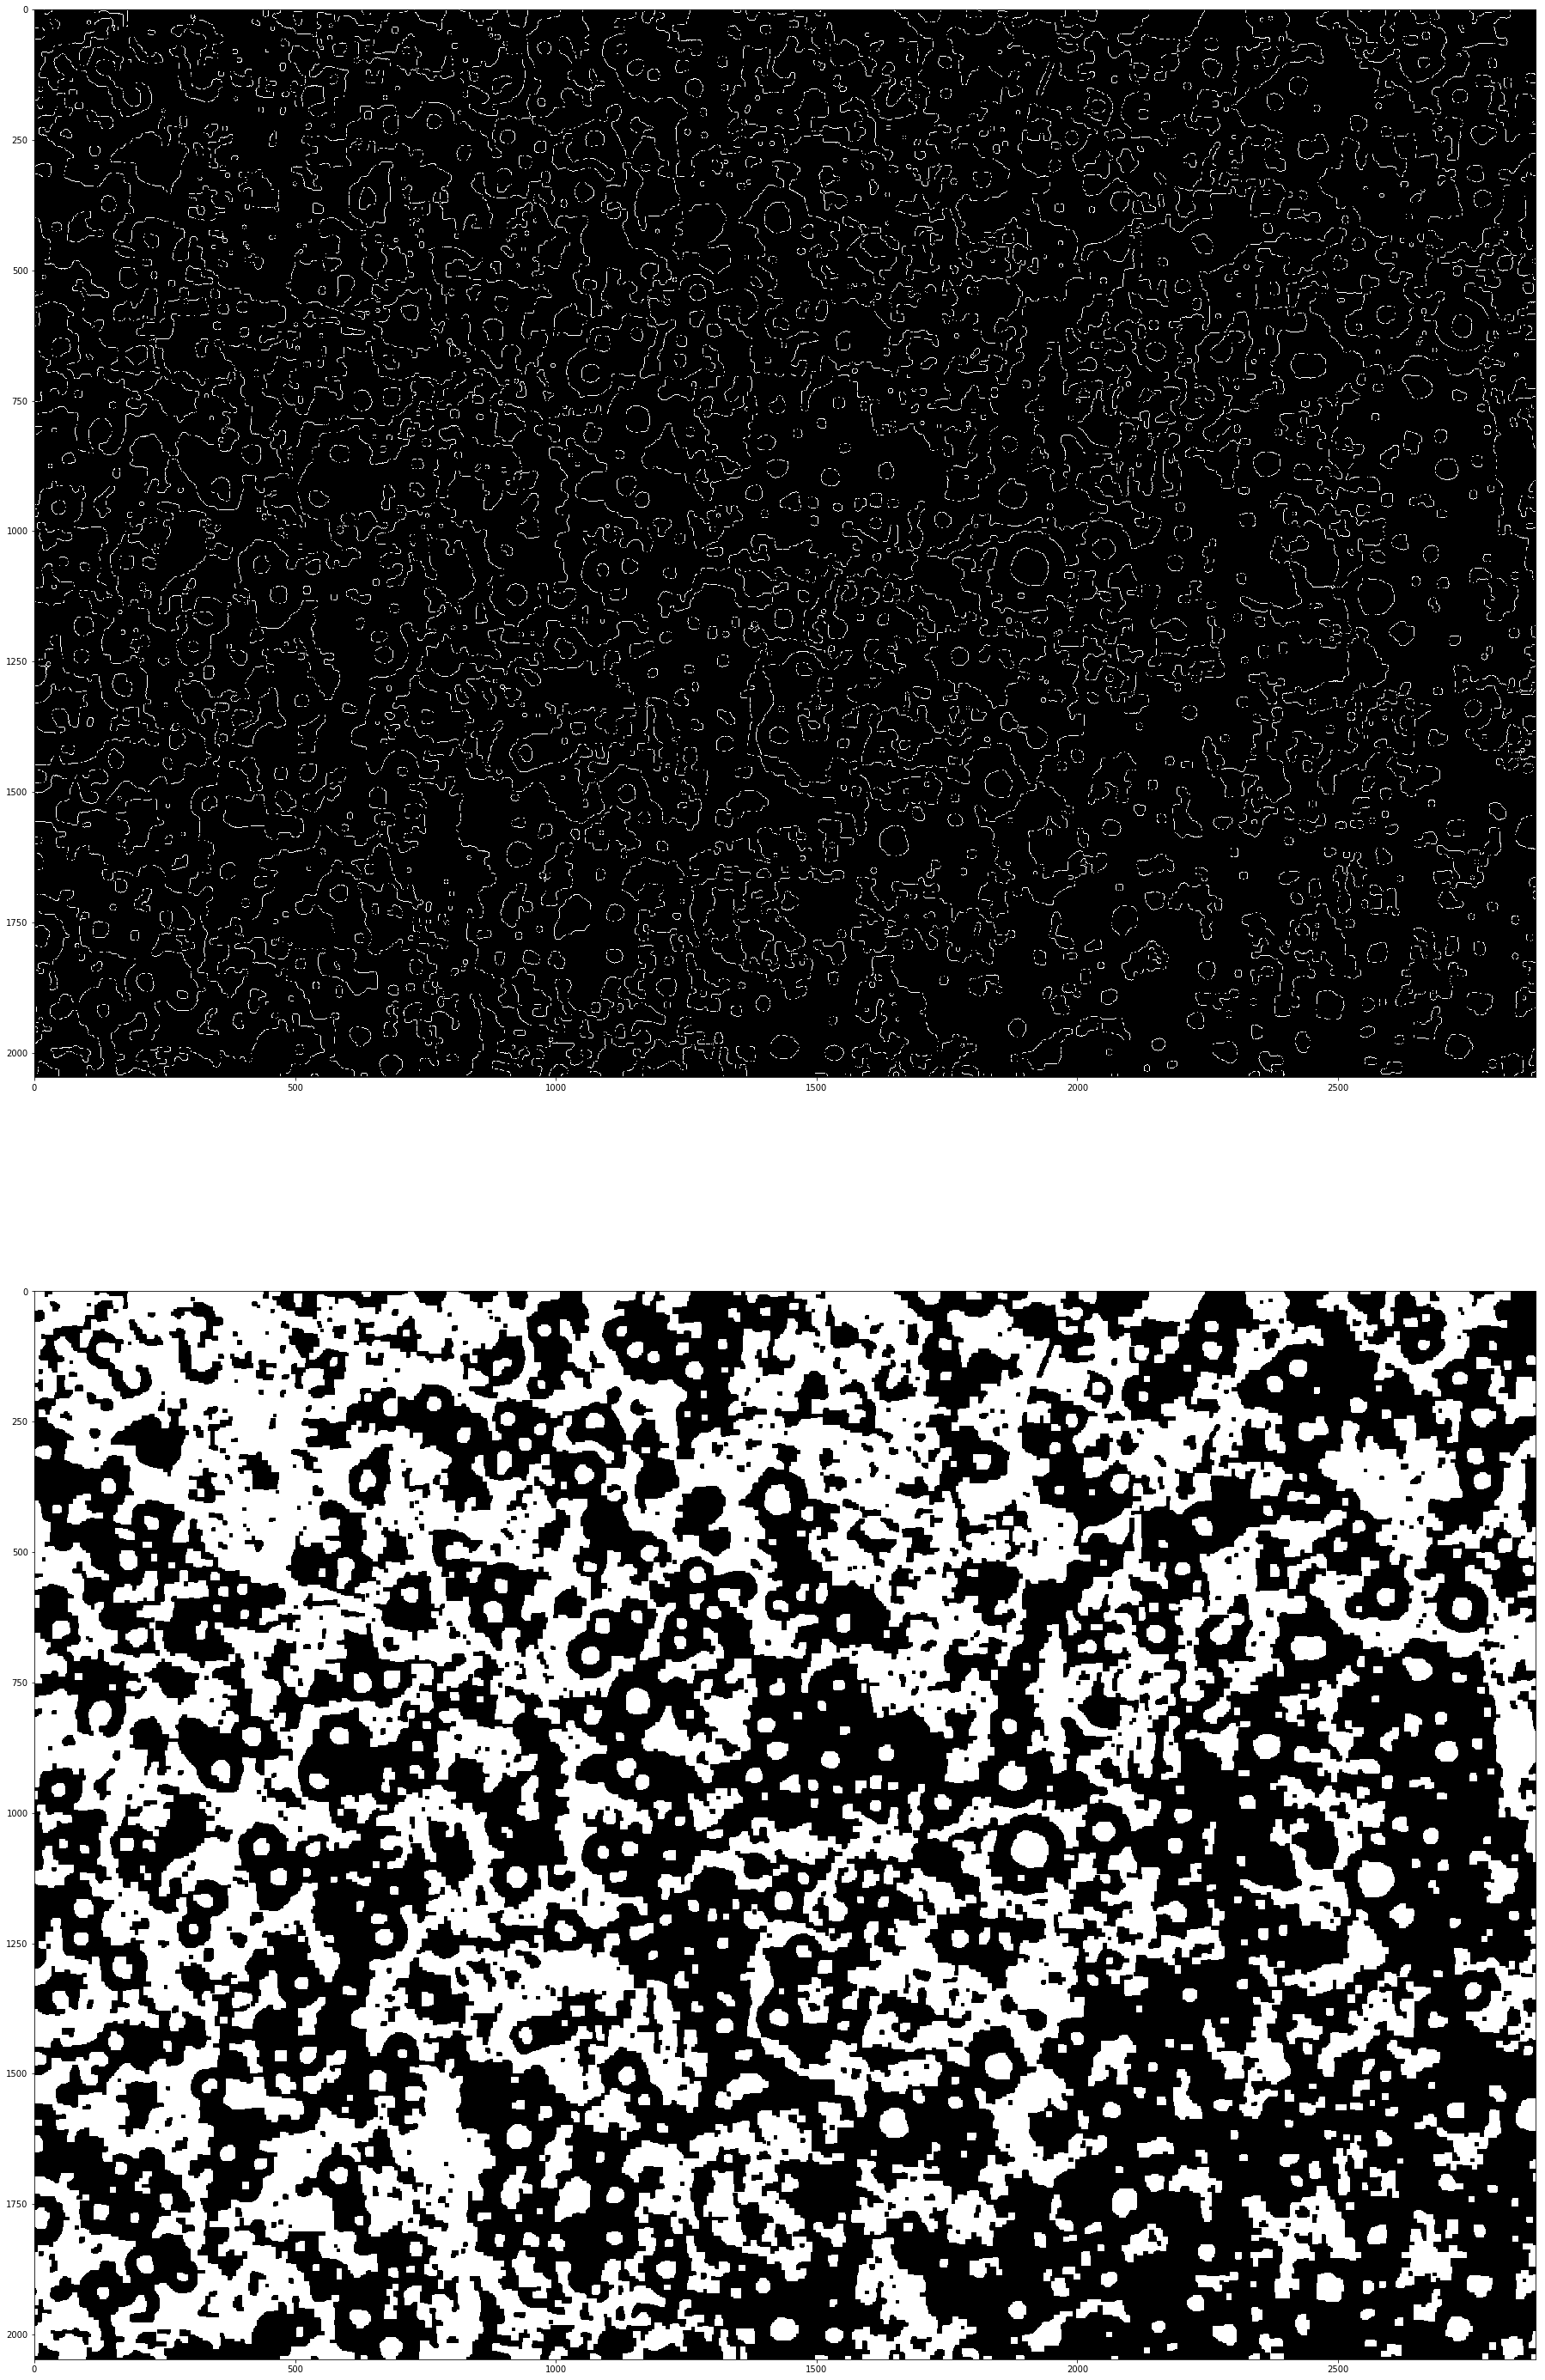

In [8]:
edges = feature.canny(erode, sigma = 2)
plt.subplot(2,1,1)
plt.imshow(edges, cmap = cm.gray)
plt.subplot(2,1,2)
plt.imshow(erode, cmap = cm.gray)

plt.subplots_adjust(left=0.5, bottom=0.5, right=5, top=10)
plt.show()

In [10]:
radius = np.arange(20,80,1)
res = hough_circle(edges,radius)
acum,cx,cy,radii = hough_circle_peaks(res,radius,total_num_peaks=3000)
print(len(cx),len(cy))

3000 3000


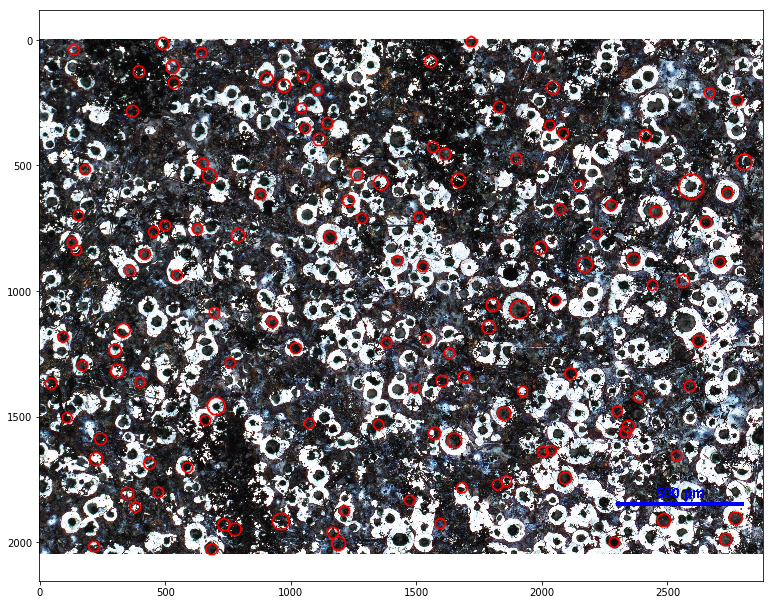

In [11]:
plt.imshow(img, cmap = cm.gray)
for f in range(len(cx)):
    a = 0
    for j in range(5):
        a = a +  sum(cx[:f]==cx[f]+j) + sum(cy[:f]==cy[f]+j) +  sum(cx[:f]==cx[f]-j) + sum(cy[:f]==cy[f]-j)
    if a==0:
        vx,vy = circle_perimeter(cx[f],cy[f],radii[f])
        plt.scatter(vx,vy,color = "r", s = 0.1)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

Se observa que para la primera metalografía se logra la idenficación de algunos granos pero no su totalidad. Aún en esta situación se observa algo de sobresegmentación y con ella la identifiación de granos ficticios.

El problema principal radica, primero, en la suposición de que todos los granos son circulares. Esta suposción es problematica ya que como algunos son circulares y otros con distintas geometrías, al aplicar el hough circle transform solo me identifica los granos circulares. Segundo, ya que el interior y exterior del grano son de igual color, esto impide el uso de mejores métodos de segmentación, como Watershed, par este problema.

In [ ]:
## Metalografía 2

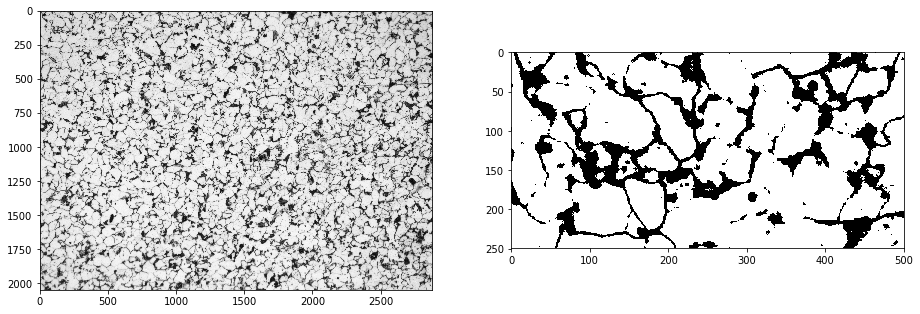

2880

In [75]:
img = cv2.imread('./200x_1010_T.tif')
img = img
gray =cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
corrected = 255 * (gray/255)**(1/0.5)
corrected2 = array(corrected, dtype=uint8)
ret, thresh = cv2.threshold(corrected2,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
thresh = cv2.bitwise_not(thresh)
subplot(1,2,1)
plt.imshow(gray,cmap=cm.gray)

subplot(1,2,2)

plt.imshow(thresh[:250,:500],cmap=cm.gray)


plt.subplots_adjust(left=0.5, bottom=0.5, right=2.5, top=5)
plt.show()
len(img[0])

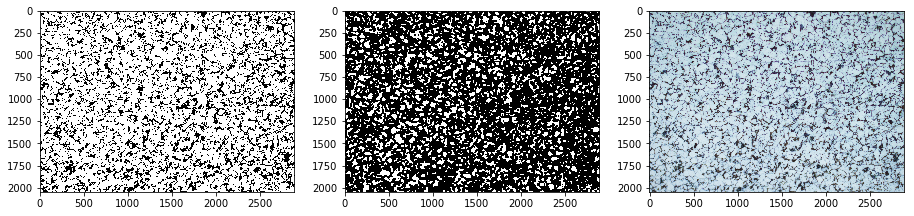

In [67]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)
close = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 1)
# sure background area
sure_bg = close


# Finding sure foreground area
sure_fg=cv2.erode(opening,kernel,iterations = 7)


subplot(1,3,1)
plt.imshow(sure_bg,cmap=cm.gray)

subplot(1,3,2)
plt.imshow(sure_fg,cmap=cm.gray)


subplot(1,3,3)
plt.imshow(img,cmap=cm.gray)

plt.subplots_adjust(left=0.5, bottom=0.5, right=2.5, top=5)
plt.show()



In [68]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0



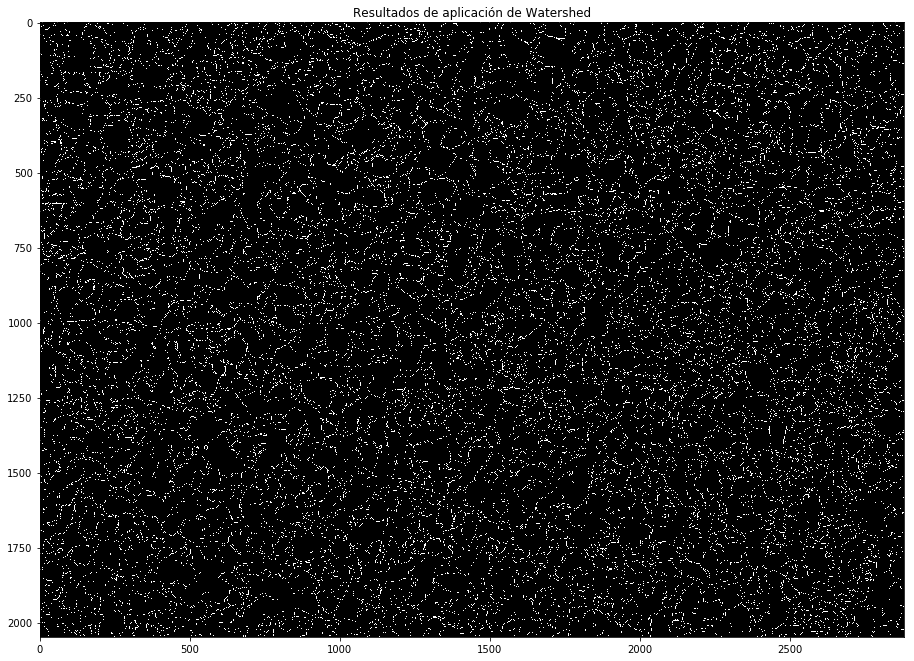

In [70]:
markers = cv2.watershed(img,markers)
nu = np.zeros((len(img), len(img[1])))
nu[markers == -1] = 1

plt.imshow(nu, cmap= cm.gray)
plt.title("Resultados de aplicación de Watershed")
plt.subplots_adjust(left=0.5, bottom=0.5, right=2.5, top=5)
plt.show()

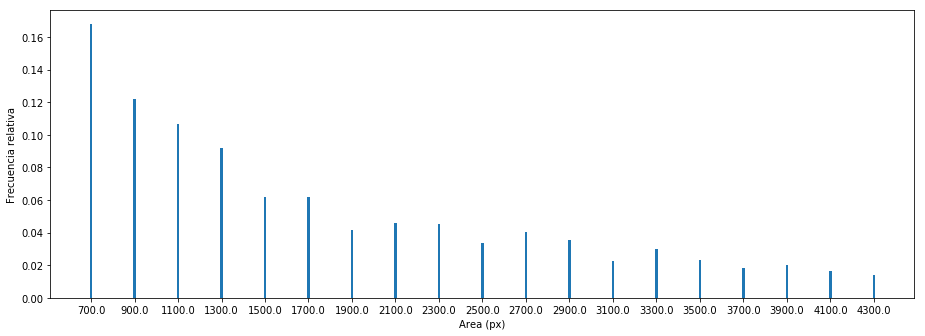

El porcentaje de datos eliminados es  63.5003054368 %


In [73]:
nu_label, num = measure.label(nu, background=1, return_num= True, connectivity = 1)
regions = measure.regionprops(nu_label)
areas = []
rep = []
for r in regions:
    a = r.area
    areas.append(a)

areas = np.array(areas)
areas = np.sort(areas)
paso = 200
threshold = areas[-int(areas.size*0.09)]
mini = ((30*25)//paso)*paso
maxi = (threshold//paso+1)*paso
markers = np.arange(mini,maxi,paso)
markers2 =[]
for j in range(len(markers)):
    m = markers[j]
    rp = sum([areas == m])+sum([areas > m])-sum([areas >= (m+paso)])
    mk = m + paso/2
    markers2.append(mk)
    rep.append(rp)
porc = (1-sum(rep)/num)*100
rep = rep/sum(rep)
plt.bar(markers2,rep,12,align='center', tick_label = markers2)
plt.xlabel("Area (px)")
plt.ylabel("Frecuencia relativa")
plt.title("Distribución de areas de loa granos")
plt.subplots_adjust(left=0.5, bottom=1, right=2.5, top=2)
plt.show() 
print("El porcentaje de datos eliminados es ", porc, "%")

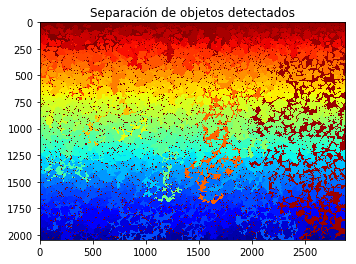

In [74]:
plt.imshow(nu_label, cmap = cm.jet_r)
plt.title("Separación de objetos detectados")
plt.show()

Se evidencia que para la segunda metalografía una gran efectividad del método Watershed para la segmentación de los objetos. Sin embargo, dado a la existencia de secciones correspondientes a sobresegmentación y en general ruido, hubo que eliminar del analisis de histograma el 63 % de los objetos detectados.

Del histograma se puede concluir que la mitad de los granos detectados tiene un area de enttre 600 y 1600 px y la otra mitad entre 1600 y 4300 px.